# MGL869 - Projet personnel

*MGL869 ETS Montreal - Production engineering*

## Abstract

## Authors
- **William PHAN**

---

## Part 1 : Collecte des données

In [1]:
from Jira import jira_download
from pandas import Index
from numpy import ndarray


### 1.1 - Téléchargement des données Jira

Nous téléchargeons les données si elles ne sont pas déjà présentes dans le dossier de données.

Renvoie le dataframe des données.

Le filtre de requête peut être défini dans le fichier config.ini.

In [2]:
jira_dataframe = jira_download()

Data already downloaded
Filter = 'project=HIVE AND issuetype=Bug AND status in (Resolved, Closed) AND affectedVersion>= 2.0.0'


### 1.2 - Nettoyer les données Jira en utilisant pandas

Auparavant, nous avons téléchargé toutes les données de Jira. Maintenant, nous allons nettoyer les données en utilisant pandas. Nous allons conserver seulement certaines colonnes et combiner certaines colonnes.

In [3]:
keep: [str] = ['Issue key', 'Status', 'Resolution', 'Created', 'Fix Versions Combined', 'Affects Versions Combined']

In [4]:
affects_version_columns: [str] = [col for col in jira_dataframe.columns if col.startswith('Affects Version/s')]
jira_dataframe['Affects Versions Combined'] = jira_dataframe[affects_version_columns].apply(
    lambda x: ', '.join(x.dropna().astype(str)), axis=1
)

In [5]:
# Combine the versions into a single column
fix_version_columns: [str] = [col for col in jira_dataframe.columns if col.startswith('Fix Version/s')]

jira_dataframe['Fix Versions Combined'] = jira_dataframe[fix_version_columns].apply(
    lambda x: ', '.join(x.dropna().astype(str)), axis=1
)
jira_dataframe = jira_dataframe.loc[:, keep]

In [6]:
# Identify columns whose names contain the string 'Issue key'
issue_key_columns: Index = jira_dataframe.columns[jira_dataframe.columns.str.contains('Issue key')]
# Extract the values from these columns as a NumPy array
issue_key_values: ndarray = jira_dataframe[issue_key_columns].values
# Flatten the array to create a one-dimensional list of all 'Issue key' values
flattened_issue_keys: ndarray = issue_key_values.flatten()
# Convert the list into a set to remove duplicates
ids: set = set(flattened_issue_keys)

---


## Part 2 : Analyse du répo git


In [7]:
from Hive import git_download, commit_analysis, update_commit_dataframe, filter_versions_by_min
from git import Repo, Tag
from pandas import DataFrame
from configparser import ConfigParser
from re import compile
from packaging import version  

### 2.1 - Clonage du répo

In [8]:
repo: Repo = git_download()

Output/hive_data/hiveRepo False
Pulling the repository: https://github.com/apache/hive.git


In [9]:
all_couples = commit_analysis(ids)

20524 couples found.


### 2.2 - Filtrage des données et couples

In [10]:
commit_dataframe: DataFrame = DataFrame(all_couples, columns=["Issue key", "File", "Commit"])

In [11]:
# Languages without whitespaces
config: ConfigParser = ConfigParser()
config.read("config.ini")
languages: [str] = config["GENERAL"]["Languages"].split(",")
languages: [str] = [lang.strip() for lang in languages]
commit_dataframe: DataFrame = commit_dataframe[commit_dataframe['File'].str.endswith(tuple(languages))]

In [37]:
couples = update_commit_dataframe(commit_dataframe, jira_dataframe)
couples
filtered_couples = couples[couples['Version Affected'].str.contains('2.3.9', na=False)]
filtered_couples

,Issue key,File,Version Affected
147,HIVE-27960,ql/src/java/org/apache/hadoop/hive/ql/exec/Reg...,"2.3.9, 4.0.0-beta-1"


### 2.3 - Collecte des versions filtrées

In [13]:
releases_regex: [str] = config["GIT"]["ReleasesRegex"].split(",")
tags: Tag = repo.tags
versions: dict = {tag.name: tag.commit for tag in tags}
releases_regex: [str] = [regex.strip() for regex in releases_regex]
releases_regex = [compile(regex) for regex in releases_regex]

In [14]:
filtered_versions = filter_versions_by_min(versions, releases_regex, "2.0.0")
filtered_versions

{'4.0.1': <git.Commit "3af4517eb8cfd9407ad34ed78a0b48b57dfaa264">,
 '2.3.10': <git.Commit "5160d3af392248255f68e41e1e0557eae4d95273">,
 '4.0.0': <git.Commit "183f8cb41d3dbed961ffd27999876468ff06690c">,
 '3.1.3': <git.Commit "4df4d75bf1e16fe0af75aad0b4179c34c07fc975">,
 '2.3.9': <git.Commit "92dd0159f440ca7863be3232f3a683a510a62b9d">,
 '2.3.8': <git.Commit "f1e87137034e4ecbe39a859d4ef44319800016d7">,
 '2.3.7': <git.Commit "cb213d88304034393d68cc31a95be24f5aac62b6">,
 '3.1.2': <git.Commit "8190d2be7b7165effa62bd21b7d60ef81fb0e4af">,
 '2.3.6': <git.Commit "2c2fdd524e8783f6e1f3ef15281cc2d5ed08728f">,
 '2.3.5': <git.Commit "76595628ae13b95162e77bba365fe4d2c60b3f29">,
 '2.3.4': <git.Commit "56acdd2120b9ce6790185c679223b8b5e884aaf2">,
 '3.1.1': <git.Commit "f4e0529634b6231a0072295da48af466cf2f10b7">,
 '3.1.0': <git.Commit "bcc7df95824831a8d2f1524e4048dfc23ab98c19">,
 '3.0.0': <git.Commit "ce61711a5fa54ab34fc74d86d521ecaeea6b072a">,
 '2.3.3': <git.Commit "3f7dde31aed44b5440563d3f9d8a8887beccf0

In [15]:
from packaging.version import Version

sorted_versions = dict(
    sorted(filtered_versions.items(), key=lambda item: Version(item[0]), reverse=True)
)

sorted_versions

{'4.0.1': <git.Commit "3af4517eb8cfd9407ad34ed78a0b48b57dfaa264">,
 '4.0.0': <git.Commit "183f8cb41d3dbed961ffd27999876468ff06690c">,
 '3.1.3': <git.Commit "4df4d75bf1e16fe0af75aad0b4179c34c07fc975">,
 '3.1.2': <git.Commit "8190d2be7b7165effa62bd21b7d60ef81fb0e4af">,
 '3.1.1': <git.Commit "f4e0529634b6231a0072295da48af466cf2f10b7">,
 '3.1.0': <git.Commit "bcc7df95824831a8d2f1524e4048dfc23ab98c19">,
 '3.0.0': <git.Commit "ce61711a5fa54ab34fc74d86d521ecaeea6b072a">,
 '2.3.10': <git.Commit "5160d3af392248255f68e41e1e0557eae4d95273">,
 '2.3.9': <git.Commit "92dd0159f440ca7863be3232f3a683a510a62b9d">,
 '2.3.8': <git.Commit "f1e87137034e4ecbe39a859d4ef44319800016d7">,
 '2.3.7': <git.Commit "cb213d88304034393d68cc31a95be24f5aac62b6">,
 '2.3.6': <git.Commit "2c2fdd524e8783f6e1f3ef15281cc2d5ed08728f">,
 '2.3.5': <git.Commit "76595628ae13b95162e77bba365fe4d2c60b3f29">,
 '2.3.4': <git.Commit "56acdd2120b9ce6790185c679223b8b5e884aaf2">,
 '2.3.3': <git.Commit "3f7dde31aed44b5440563d3f9d8a8887beccf0

## Part 3. - Analyse des métriques statiques via Understand

In [16]:
from Understand.commands import und_create_command, und_purge_command
from Understand.metrics import metrics
from Understand.label import label_all_metrics
from os import path
from Understand import merge_static_metrics
from Understand.enrich import enrich_metrics
from Understand.update import merge_all_metrics

### 3.1 - Création du projet Understand

In [17]:
hive_git_directory: str = config["GIT"]["HiveGitDirectory"]
data_directory: str = config["GENERAL"]["DataDirectory"]
understand_project_name : str = config["UNDERSTAND"]["UnderstandProjectName"]

understand_project_path : str = path.join(data_directory, hive_git_directory, understand_project_name)

if not path.exists(understand_project_path):
    und_create_command()

In [18]:
und_purge_command()

Running command : 
     /Applications/Understand.app/Contents/MacOS/und purge -db Output/hive_data/hive.und
Database purged.



### 3.2 - Extraction des métriques


In [19]:
metrics(filtered_versions)

Metrics analysis is skipped as per configuration.


### 3.3 - Labélisation


In [20]:
label_all_metrics(couples)

Labelization process is skipped as per configuration.


In [21]:
enrich_metrics(couples)

Enrichment process is skipped as per configuration.


In [22]:
v = [
    "2.0.0", "2.0.1", "2.1.0", "2.1.1", "2.2.0", "2.3.0", "2.3.1", "2.3.2",
    "2.3.3", "2.3.4", "2.3.5", "2.3.6", "2.3.7", "2.3.8", "2.3.9", "2.3.10",
    "3.0.0", "3.1.0", "3.1.1", "3.1.2", "3.1.3", "4.0.0", "4.0.1"
]
merge_all_metrics(v)

Merging has already been done. Skipping...


In [23]:
merge_static_metrics()

Merging has already been done. Skipping...


# Part 4. - Entraînement du modèle

In [24]:
import os
from configparser import ConfigParser
from AI import plot_feature_importance_rf, plot_shap_summary,plot_shap_with_others, evaluate_model, train_model, load_and_prepare_data, load_config
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


In [25]:
config: ConfigParser = ConfigParser()
config.read("config.ini")

['config.ini']

### 4.1 - Evaluation of RF and LR models for all versions

Dans cette partie, il est important de souligner que le modèle construit se base sur les données du csv augmentée contenant le résultat de TOUTES les versions taguées depuis la 2.0.0. Le fichier se trouve dans le dossier src/Output/temp_static_metrics_output

In [26]:
data_directory = config["GENERAL"]["DataDirectory"]
output_dir = config["UNDERSTAND"]["FullStaticMetricsOutputDirectory"]
file_name = config["UNDERSTAND"]["MergedStaticMetricsFileName"]
file_path = os.path.join(data_directory, output_dir, file_name)

In [27]:
# Retrieve configuration settings
config_section = "VERSION_ALL_LAB"
param = load_config(config_section)

model_instance_lr = LogisticRegression(max_iter=5000, class_weight='balanced')
print("Running pipeline with the model: Logistic Regression")
X_train_lr, X_test_lr, y_train_lr, y_test_lr = load_and_prepare_data(file_path,param)
trained_model_lr = train_model(model_instance_lr, X_train_lr, y_train_lr)
metrics_lr = evaluate_model(trained_model_lr, X_test_lr, y_test_lr) 

# Random Forest
model_instance_rf = RandomForestClassifier(class_weight='balanced')
X_train_rf, X_test_rf, y_train_rf, y_test_rf = load_and_prepare_data(file_path,param)
print("Running pipeline with the model: Random Forest")
trained_model_rf = train_model(model_instance_rf, X_train_rf, y_train_rf)
metrics_rf = evaluate_model(trained_model_rf, X_test_rf, y_test_rf)




Running pipeline with the model: Logistic Regression
Scaler fit/transform time: 0.03 seconds
Class distribution before resampling: Counter({0: 116795, 1: 8374})
Class distribution after resampling: Counter({1: 116795, 0: 116795})
Training time: 1.53 seconds
Prediction time: 0.01 seconds
Scaler fit/transform time: 0.04 seconds
Class distribution before resampling: Counter({0: 116795, 1: 8374})
Class distribution after resampling: Counter({1: 116795, 0: 116795})
Running pipeline with the model: Random Forest
Training time: 31.20 seconds
Prediction time: 0.97 seconds


In [28]:
metrics_lr

{'AUC': np.float64(0.6388558821428626),
 'Precision': np.float64(0.6357673121489453),
 'Recall': np.float64(0.4610476543139545),
 'FPR': array([0.        , 0.        , 0.        , ..., 0.99979983, 0.99994281,
        1.        ]),
 'TPR': array([0.00000000e+00, 2.84843479e-05, 2.84843479e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00])}

In [29]:
metrics_rf

{'AUC': np.float64(0.9651860675878594),
 'Precision': np.float64(0.9581712644365986),
 'Recall': np.float64(0.9121827555758111),
 'FPR': array([0.        , 0.00300257, 0.00300257, ..., 0.53720332, 0.53726051,
        1.        ]),
 'TPR': array([0.        , 0.18745549, 0.18756943, ..., 0.97829493, 0.97829493,
        1.        ])}

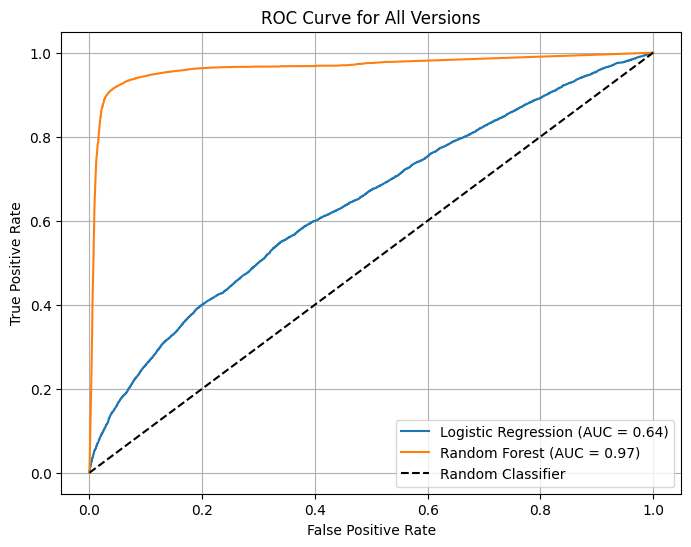

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(metrics_lr["FPR"], metrics_lr["TPR"],
         label=f"Logistic Regression (AUC = {metrics_lr['AUC']:.2f})")
plt.plot(metrics_rf["FPR"], metrics_rf["TPR"],
         label=f"Random Forest (AUC = {metrics_rf['AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for All Versions')
plt.legend()
plt.grid()
plt.show()


#### Analyse des métriques :
AUC (aire sous la courbe ROC):
L’AUC de Random Forest (0.96) est largement supérieure à celle de Logistic Regression (0.64). Cela montre que Random Forest est bien meilleur pour séparer les classes (positifs vs négatifs).

Précision :
Random Forest a une précision de 96 % contre 63 % pour Logistic Regression. Cela signifie que Random Forest fait beaucoup moins d’erreurs quand il prédit une classe positive.

Rappel (Recall) :
Avec un rappel de 91 %, Random Forest détecte presque tous les vrais positifs, alors que Logistic Regression n’en détecte que 46 %.

#### Conclusion :
Le modèle Random Forest est clairement le plus performant. Voici pourquoi :

Il a un AUC proche de 1, ce qui montre qu'il distingue très bien les classes positives et négatives.
Il est très précis (96 %) dans ses prédictions.
Il détecte la grande majorité des positifs réels grâce à son rappel élevé (91 %).

### 4.2 Étude de l'importance des métriques appliqué au modèle de régression linéaire (LR)

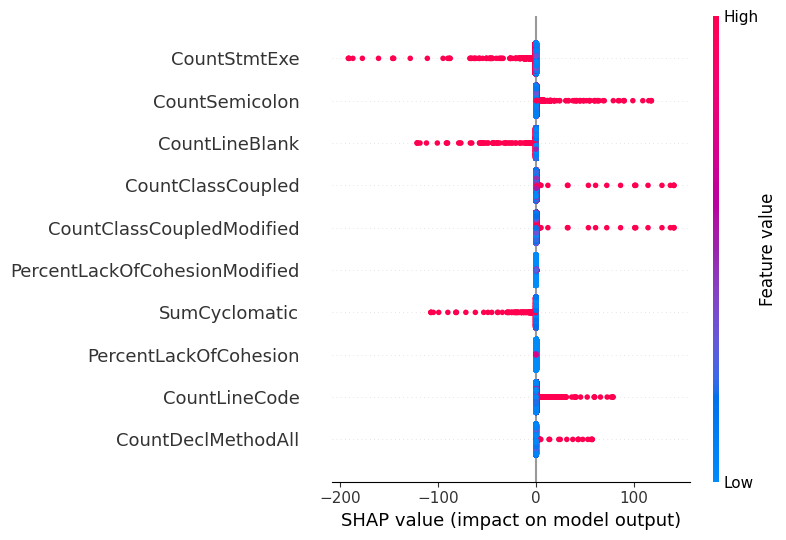

In [31]:
plot_shap_summary(trained_model=trained_model_lr, X_train=X_train_lr, X_test=X_test_lr, top_n=10)

#### Analyse : CountSemicolon 

Rouge à droite (valeurs élevées) : Les valeurs élevées de CountSemicolon (points rouges) tendent à être à droite (SHAP positif). Cela indique qu'un grand nombre de points-virgules dans un fichier augmente la probabilité qu'il contienne un bogue.
Bleu (valeurs faibles) : Les faibles valeurs de CountSemicolon (points bleus) sont centrées autour de zéro. Cela signifie que lorsque CountSemicolon est faible, cette variable a peu d'influence sur la prédiction.

#### Analyse : CountStmtExe
Rouge à gauche (SHAP négatif) :

Les points rouges indiquent des valeurs élevées de CountStmtExe.
Ces points rouges sont majoritairement situés à gauche (valeurs SHAP négatives). Cela signifie que plus la valeur de CountStmtExe est élevée, plus elle diminue la probabilité qu'un fichier contienne un bug.
Impact sur les prédictions :

Grand nombre de points rouges à gauche :
Cela montre que beaucoup de fichiers avec des valeurs élevées de CountStmtExe (nombre d'instructions exécutables) réduisent la probabilité prédite d’un bug.
Cela peut indiquer que des fichiers contenant un grand nombre d’instructions exécutables (potentiellement bien organisées ou bien testées) sont moins susceptibles de contenir des bugs.

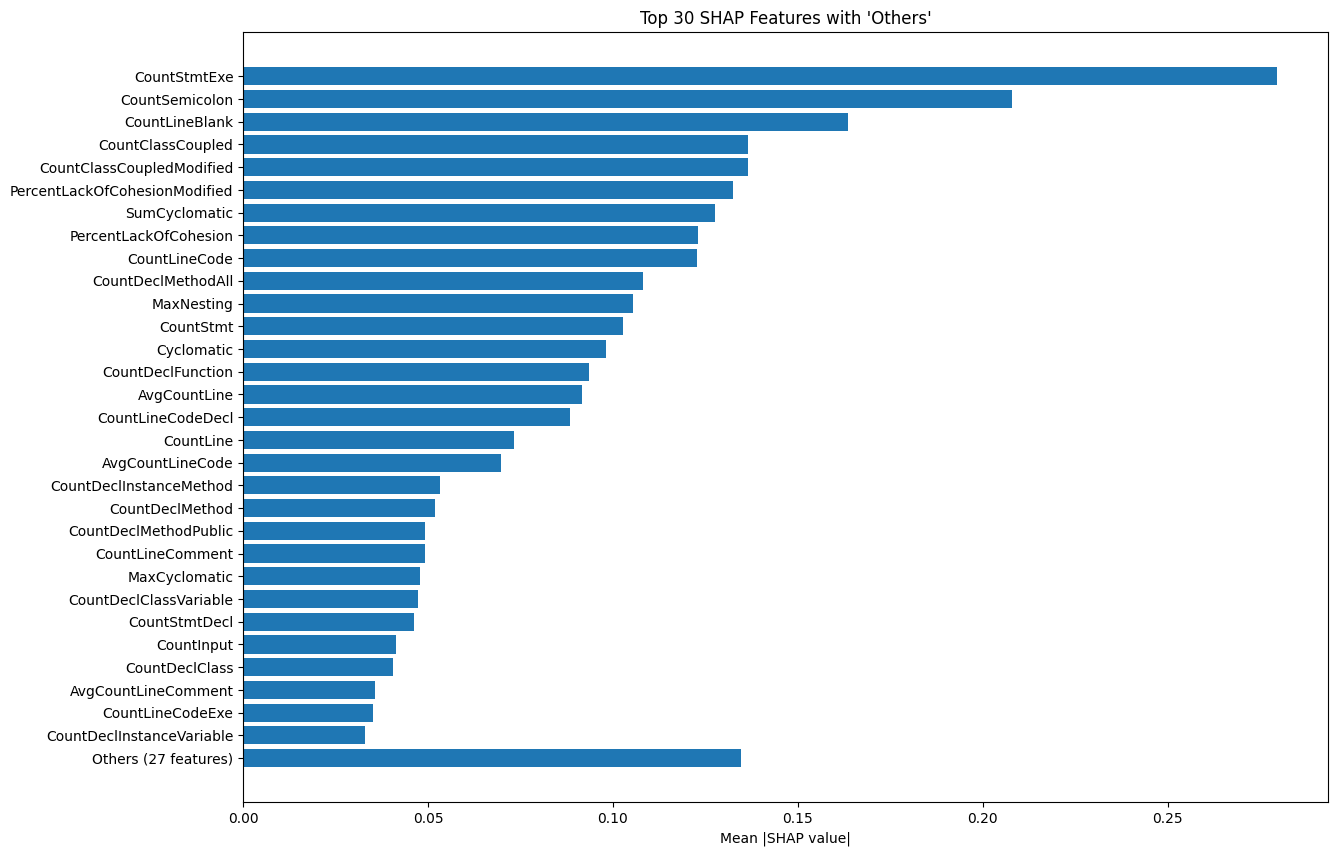

In [32]:
plot_shap_with_others(trained_model=trained_model_lr, X_train=X_train_lr, X_test=X_test_lr, top_n=30)


Cette vue résume uniquement l’importance globale (moyenne) absolue, sans afficher les relations locales ni les distributions.

### 4.3 Étude de l'importance des métriques appliqué au modèle de forêt aléatoire (RF)

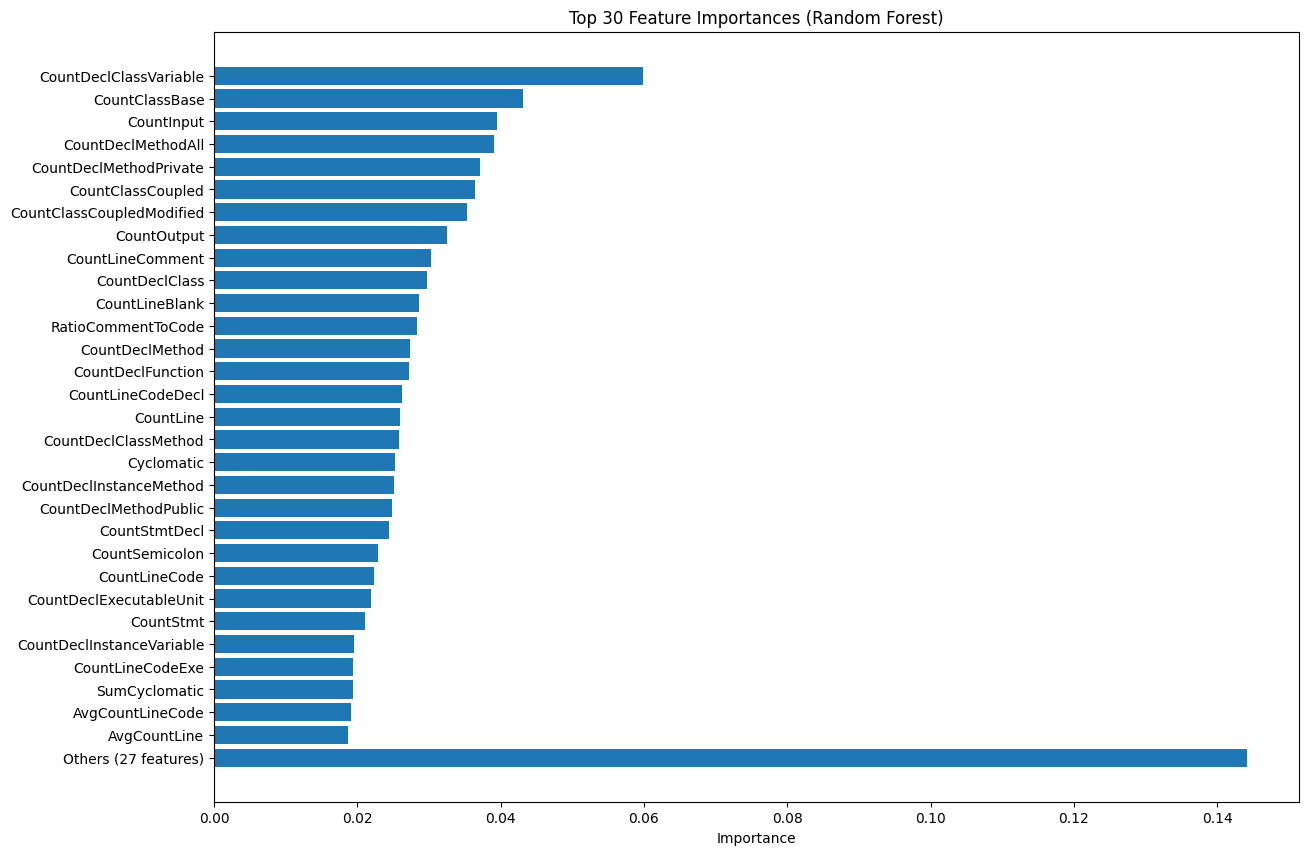

In [33]:
plot_feature_importance_rf(trained_model_rf=trained_model_rf, feature_columns=X_train_rf.columns, top_n=30)

### Analyse des résultats et suggestions d'actions pour éviter les bogues

À partir des graphiques montrant les **importances des variables** et les **valeurs SHAP** dans Random Forest uniquement (le meilldeur modèle), nous pouvons identifier les métriques ayant le plus d'impact sur la probabilité de présence d'un bogue. Ces analyses permettent de proposer des actions concrètes pour améliorer la qualité du code et éviter des bogues.

---

#### Actions proposées :

1. **Réduire le nombre de déclarations de variables dans les classes (`CountDeclClassVariable`)**
   - **Observation :** `CountDeclClassVariable` est la métrique la plus influente. Un grand nombre de variables déclarées dans une classe peut rendre le code complexe, difficile à maintenir, et sujet à des erreurs.
   - **Action :**
     - Encourager la modularisation des classes en utilisant des sous-classes ou des objets pour encapsuler les variables liées.
     - Limiter le nombre de variables par classe avec des revues de code automatiques.
   - **Justification :**
     - Une classe plus concise facilite la lisibilité et diminue les risques d’introduction de bogues liés à des dépendances complexes.



2. **Optimiser la gestion des classes de base (`CountClassBase`)**
   - **Observation :** Le nombre de classes de base est fortement corrélé à la probabilité de bogues. Cela peut indiquer des hiérarchies de classes complexes ou mal conçues.
   - **Action :**
     - Simplifier les hiérarchies de classes en limitant la profondeur d’héritage.
     - Appliquer des principes de conception comme **Composition over Inheritance** pour réduire la dépendance à de multiples classes de base.
   - **Justification :**
     - Des hiérarchies simplifiées favorisent une meilleure lisibilité et limitent les erreurs dues à des relations mal comprises entre classes.



3. **Réduire la complexité des entrées (`CountInput`)**
   - **Observation :** Un nombre élevé d’entrées peut indiquer une complexité dans la gestion des données ou une forte dépendance à des sources externes.
   - **Action :**
     - Standardiser les formats d’entrée et limiter les dépendances aux données externes non fiables.
     - Ajouter des validations robustes pour éviter les erreurs dues à des données inattendues.
   - **Justification :**
     - Une gestion claire et standardisée des entrées diminue les risques d’erreurs dues à des données mal formées ou non prévues.



4. **Contrôler le nombre total de méthodes déclarées (`CountDeclMethodAll`)**
   - **Observation :** Un grand nombre de méthodes déclarées est corrélé à une complexité accrue, ce qui augmente les risques de bogues.
   - **Action :**
     - Refactoriser les classes pour réduire le nombre de méthodes, par exemple en regroupant des fonctionnalités similaires.
     - Limiter le nombre de méthodes publiques pour réduire l’exposition à des erreurs externes.
   - **Justification :**
     - Réduire le nombre de méthodes facilite la compréhension et diminue les risques d’introduire des erreurs dans des classes complexes. **Attention**, cependant une subdivision trop pauvre du code aura un effet inverse !



5. **Limiter les modifications de couplage des classes (`CountClassCoupledModified`)**
   - **Observation :** Les modifications fréquentes des relations entre classes couplées sont associées à une probabilité accrue de bogues.
   - **Action :**
     - Minimiser les modifications fréquentes des classes couplées en favorisant la stabilité des interfaces.
     - Utiliser des tests automatisés pour valider les modifications dans les dépendances.
   - **Justification :**
     - Réduire les modifications dans des dépendances critiques diminue le risque d’introduire des bogues dans les interactions entre classes.


---

### ... Vers une analyse plus fine
Bien que ces analyses offrent des perspectives globales basées sur toutes les versions combinées, elles ne tiennent pas compte de l'évolution des métriques au fil des versions. Il serait pertinent d'explorer comment ces métriques varient entre les versions pour mieux comprendre l'impact des changements dans le temps. Cela permettra d'identifier des tendances ou des patterns susceptibles de causer des bogues dans les futures versions.


## Part 5. - Limitations du modèle


In [1]:
from AI import plot_feature_importance_rf, plot_shap_summary,plot_shap_with_others, evaluate_model, train_model, load_and_prepare_data, load_config, train_and_save_models

In [ ]:
train_and_save_models()

Processing version: 2.1.0
Processing version: 3.0.0
Processing version: 4.0.0
Results saved to Output/model_static_results/static_performance_metrics.json


## Part 6. - Dynamic Metrics

In [ ]:
from Dynamic import convert_json_to_csv, merge_static_and_dynamic_csv, build_dependencies, display_hierarchy, collect_dynamic_metrics_v2
from Hive import filter_versions_by_min

In [ ]:
all_versions = filter_versions_by_min(versions, releases_regex,'1.0')
version_json = build_dependencies(all_versions)
#display_hierarchy(version_json)
#version_json

In [ ]:
dynamic_metrics = collect_dynamic_metrics_v2(version_json)

In [ ]:
convert_json_to_csv()

In [ ]:
merge_static_and_dynamic_csv()